In [17]:
from allennlp.common import Params
from allennlp.data import DatasetReader
from allennlp.data.dataset import Batch
from allennlp.data.iterators import BasicIterator, BucketIterator, DataIterator

from allennlp.models import Model

from allennlp.nn.util import move_to_device
from tqdm import tqdm

import pandas as pd
from collections import defaultdict, OrderedDict

In [2]:
import sys
sys.path.append('/home/emelyanov-yi/PycharmProjects/kaggle_tf2_qa/')

In [3]:
from src import NaturalQuestionsModel, NaturalQuestionsDatasetReader

In [4]:
from typing import List, Dict, Tuple, Optional
import torch

In [5]:
prefix = '/home/emelyanov-yi/models/tf2_qa/main_lstm_bert_negatives_0.02'

In [6]:
params = Params.from_file(prefix + '/config.json')

In [7]:
model = Model.load(params, prefix).to('cuda')
model_device = next(model.parameters()).device
vocab = model.vocab

In [8]:
reader = DatasetReader.from_params(params['dataset_reader'].duplicate())
reader._downsample_negative = 1.1
reader._downsample_all = 1.1

In [9]:
instances_gen = reader.read(params['validation_data_path'])

In [12]:
iterator = DataIterator.from_params(params['iterator'].duplicate())
iterator.index_with(vocab)

In [13]:
batch_iterator = iterator(instances_gen)

# Here we store our results

In [21]:
results_list: List[Dict] = []

In [22]:
for batch in tqdm(batch_iterator):
    batch = move_to_device(batch, 0 if model_device else -1)
    batch_results = model(**batch)
    for k, v in batch_results.items():
        # returned loss if scalar (0-dimensional tensor)
        if isinstance(v, torch.Tensor):
            batch_results[k] = v.detach().cpu()
    batch_size = len(batch_results['meta'])
    for i in range(batch_size):
        temp_dict = {}
        for k, v in batch_results.items():
            # returned loss if scalar (0-dimensional tensor)
            if isinstance(v, torch.Tensor):
                if v.ndim > 0:
                    temp_dict[k] = v[i, ...]
            elif isinstance(v, list):
                temp_dict[k] = v[i]
            else:
                raise RuntimeError(f'Model returned container of type {type(v)}')
        temp_dict.update(**temp_dict['meta'])
        results_list.append(temp_dict)
    # break

1it [00:01,  1.02s/it]Too many wordpieces, truncating sequence. If you would like a sliding window, set `truncate_long_sequences` to False.The offending input was: ['[CLS]', 'the', 'name', 'of', 'the', 'separatist', 'political', 'party', 'in', 'quebec', '[SEP]', '<Ul>', '<Li>', 'Richard', 'Rohmer', "'s", 'novel', 'Separation', '(', '1976', ')', 'was', 'turned', 'into', 'a', 'TV', '-', 'movie', 'for', 'CTV', 'Television', 'in', '1977', '.', 'In', 'the', 'movie', ',', 'the', 'Parti', 'Québécois', 'has', 'formed', 'the', 'government', 'of', 'Quebec', 'but', 'Premier', 'Gaston', 'Belisle', 'has', 'repeatedly', 'put', 'off', 'its', 'promise', 'to', 'hold', 'a', 'referendum', '.', 'International', 'politics', 'forces', 'Belisle', "'s", 'hand', '.', '</Li>', '<Li>', 'In', 'the', 'mid-1980s', ',', 'a', 'second', 'movie', ',', 'Quebec', '-', 'Canada', '1995', ',', 'depicts', 'a', 'meeting', 'between', 'the', 'president', 'of', 'Quebec', 'and', 'the', 'prime', 'minister', 'of', 'Canada', 'to', '

KeyboardInterrupt: 

In [23]:
len(results_list)

289104

In [28]:
print(inst)

Instance with fields:
 	 context: TextField of length 62 with text: 
 		[[CLS], the, name, of, the, separatist, political, party, in, quebec, [SEP], <Table>, <Tr>, <Td>,
		</Td>, <Td>, This, article, needs, additional, citations, for, verification, ., Please, help,
		improve, this, article, by, adding, citations, to, reliable, sources, ., Unsourced, material, may,
		be, challenged, and, removed, ., (, April, 2010, ), (, Learn, how, and, when, to, remove, this,
		template, message, ), </Td>, </Tr>, </Table>]
 		and TokenIndexers : {'tokens': 'PretrainedBertIndexer'} 
 	 meta: MetadataField (print field.metadata to see specific information). 
 	 answer_start: IndexField with index: 10. 
 	 answer_end: IndexField with index: 10. 
 	 answer_label: LabelField with label: not_relevant in namespace: 'answer_labels'.' 



# From predictions for all paragraphs to one document-level prediction

In [37]:
results: List[Dict] = []
for inst in tqdm(instances_gen):
    batch = Batch([inst])
    batch.index_instances(model.vocab)
    res = model.forward_on_instance(inst)
    
    res.update(**res['meta'])
    results.append(res)

135it [00:16, 13.40it/s]Too many wordpieces, truncating sequence. If you would like a sliding window, set `truncate_long_sequences` to False.The offending input was: ['[CLS]', 'the', 'name', 'of', 'the', 'separatist', 'political', 'party', 'in', 'quebec', '[SEP]', '<Ul>', '<Li>', 'Richard', 'Rohmer', "'s", 'novel', 'Separation', '(', '1976', ')', 'was', 'turned', 'into', 'a', 'TV', '-', 'movie', 'for', 'CTV', 'Television', 'in', '1977', '.', 'In', 'the', 'movie', ',', 'the', 'Parti', 'Québécois', 'has', 'formed', 'the', 'government', 'of', 'Quebec', 'but', 'Premier', 'Gaston', 'Belisle', 'has', 'repeatedly', 'put', 'off', 'its', 'promise', 'to', 'hold', 'a', 'referendum', '.', 'International', 'politics', 'forces', 'Belisle', "'s", 'hand', '.', '</Li>', '<Li>', 'In', 'the', 'mid-1980s', ',', 'a', 'second', 'movie', ',', 'Quebec', '-', 'Canada', '1995', ',', 'depicts', 'a', 'meeting', 'between', 'the', 'president', 'of', 'Quebec', 'and', 'the', 'prime', 'minister', 'of', 'Canada', 'to',

KeyboardInterrupt: 

In [26]:
docwise_results = defaultdict(list)
for res in results_list:
    docwise_results[res['example_id']].append(res)

In [30]:
result.keys()

dict_keys(['start_logits', 'end_logits', 'label_logits', 'mask', 'meta', 'example_id', 'candidate_start_token', 'text', 'query', 'offset'])

In [31]:
predictions: Dict[str, Tuple] = {}
    
for doc_id, all_results in tqdm(docwise_results.items()):
    long_answer_candidate = None
    for result in all_results:
        predicted_label = vocab.get_token_from_index(result['label_logits'].argmax().item(), namespace='answer_labels')
        if predicted_label in ['YES', 'NO']:
            # when we predict yes-no answer, we use current paragraph as long answer and do not check other paragraphs at all
            # TODO: get best match based on logits
            predictions[doc_id] = ((result['candidate_start_token'], result['candidate_start_token'] + len(result['text'])), predicted_label)
            break
        elif predicted_label == 'NONE':
            # paragraph is at least relevant, save it if there will be no other such prediction in the future
            # get predicted short answer (if exists)
            offset = result['offset']
            short_answer_start = res['start_logits'].argmax() - offset
            short_answer_end = res['end_logits'].argmax() - offset
            if short_answer_end >= short_answer_start \
                and short_answer_start >= 0:
                # found good short answer, break
                predictions[doc_id] = (long_answer_candidate, (short_answer_start, short_answer_end))
                break
            else:
                long_answer_candidate = (result['candidate_start_token'], result['candidate_start_token'] + len(result['text']))
    if long_answer_candidate is not None:
        predictions[doc_id] = (long_answer_candidate, '')
    else:
        predictions[doc_id] = ('', '')
    # break

100%|██████████| 2226/2226 [00:00<00:00, 2695.32it/s]


In [32]:
submission: Dict[str, str] = OrderedDict()
for doc_id in docwise_results:
    long_answer, short_answer = predictions[doc_id]
    if not long_answer:
        submission[f'{doc_id}_long'] = ''
    else:
        submission[f'{doc_id}_long'] = '{}:{}'.format(*long_answer)
    if not short_answer:
        submission[f'{doc_id}_short'] = ''
    elif isinstance(short_answer, str):
        submission[f'{doc_id}_short'] = short_answer 
    elif isinstance(short_answer, tuple):
        submission[f'{doc_id}_short'] = '{}:{}'.format(*short_answer)
    else:
        raise RuntimeError(f'Short answer {short_answer} not understood.')
    # break

In [75]:
submission

OrderedDict([('-1258974036110822789_long', '79:118'),
             ('-1258974036110822789_short', ''),
             ('-745542277813407309_long', '90:141'),
             ('-745542277813407309_short', ''),
             ('-3489053283041023861_long', ''),
             ('-3489053283041023861_short', ''),
             ('-4660970382607895773_long', ''),
             ('-4660970382607895773_short', ''),
             ('-2286041252427312305_long', '346:524'),
             ('-2286041252427312305_short', ''),
             ('-3594846094801386035_long', '805:927'),
             ('-3594846094801386035_short', ''),
             ('1100531970231406189_long', ''),
             ('1100531970231406189_short', ''),
             ('-4242445176318660699_long', '130:253'),
             ('-4242445176318660699_short', ''),
             ('-8610711774716247943_long', ''),
             ('-8610711774716247943_short', ''),
             ('-7912859676267745845_long', '201:250'),
             ('-7912859676267745845_short',

In [37]:
submission['-1258974036110822789_long']

''

In [38]:
df = pd.DataFrame([{'example_id': k, 'PredictionString': v} for k, v in submission.items()])

In [42]:
df.PredictionString.astype(bool).sum()

167

In [66]:
doc_id

-1258974036110822789

In [30]:
inst['meta'].metadata['candidate_start_token']

16

In [55]:
'{}__{}'.format(*(1, 2))

'1__2'

In [ ]:
dir(str)

In [20]:
import jsonlines

In [21]:
with jsonlines.open(params['validation_data_path']) as reader:
    for line in reader:
        break

In [22]:
line.keys()

dict_keys(['document_text', 'long_answer_candidates', 'question_text', 'annotations', 'document_url', 'example_id'])

In [29]:
line['long_answer_candidates']

[{'start_token': 16, 'top_level': True, 'end_token': 67},
 {'start_token': 17, 'top_level': False, 'end_token': 66},
 {'start_token': 79, 'top_level': True, 'end_token': 118},
 {'start_token': 118, 'top_level': True, 'end_token': 381},
 {'start_token': 381, 'top_level': True, 'end_token': 497},
 {'start_token': 497, 'top_level': True, 'end_token': 607},
 {'start_token': 607, 'top_level': True, 'end_token': 678},
 {'start_token': 907, 'top_level': True, 'end_token': 963},
 {'start_token': 971, 'top_level': True, 'end_token': 1084},
 {'start_token': 1084, 'top_level': True, 'end_token': 1174},
 {'start_token': 1174, 'top_level': True, 'end_token': 1316},
 {'start_token': 1339, 'top_level': True, 'end_token': 1637},
 {'start_token': 1637, 'top_level': True, 'end_token': 1823},
 {'start_token': 1830, 'top_level': True, 'end_token': 1903},
 {'start_token': 1903, 'top_level': True, 'end_token': 2030},
 {'start_token': 2030, 'top_level': True, 'end_token': 2181},
 {'start_token': 2181, 'top_l

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
res['start_logits']

array([2.74120527e-12, 3.58257781e-12, 2.27677772e-12, 4.98013714e-11,
       1.75781449e-12, 3.93584228e-11, 2.65977018e-10, 2.47831053e-12,
       1.48078882e-10, 1.00000000e+00, 5.00546566e-12, 2.54231983e-11,
       2.72890814e-13, 7.21567988e-13, 1.86188386e-13, 8.06734440e-14,
       1.38707229e-13, 2.50405301e-13, 1.61096356e-13, 2.14020072e-13,
       1.43250090e-13, 5.75047226e-13, 1.77148538e-13, 1.84621090e-13,
       2.11917967e-13, 2.64569508e-13, 9.17822784e-13, 1.50097315e-13,
       1.70493082e-13, 8.20020321e-14, 1.00831520e-13, 1.08939645e-13,
       2.11119189e-09, 1.27482186e-13, 1.80516761e-13, 1.32638651e-13,
       7.32685017e-13, 6.41841940e-13, 1.78506610e-13, 1.64872605e-13,
       1.49719890e-13, 1.15443056e-13, 3.35153482e-13, 7.36383719e-13,
       1.59665656e-13, 5.13281431e-12, 6.47599108e-14, 1.55645164e-13,
       2.10130497e-13, 1.35983144e-13, 2.09678087e-13, 2.71303759e-13,
       1.35278968e-13, 1.80635942e-13, 9.07738579e-14, 2.36311052e-13,
      

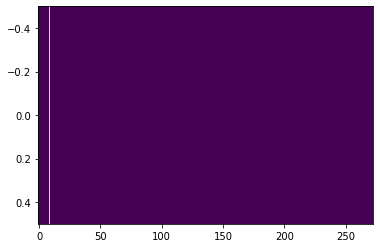

In [48]:
plt.imshow(res['start_logits'].reshape(1, -1), aspect='auto')